In [48]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan']
ACTIVITIES = ['sit', 'walk', 'upstair']
CHUNK_SIZE = 0.5  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
START_FROM, END_TO = 200, 300
NUM_CLASSES = 3 

In [43]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=500, time_end=8000):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [44]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities, sampling_rate):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)  # Convert time to sample count

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // chunk_samples  # Number of full chunks
        for j in range(num_chunks):
            start = j * chunk_samples
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

In [45]:
# Save function
def save_model(model, optimizer, filename="model.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")
# Load function
def load_model(model, optimizer, filename="model.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {filename}")

In [58]:
# Convert the data to NumPy arrays
training_data = np.array(training_data)
testing_data = np.array(testing_data)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape: (num_samples, 3, chunk_size*100)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

In [59]:
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes, input_channels=3, seq_length=int(CHUNK_SIZE * 100)):
        super(OptimizedCNNModel, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):
            """Depthwise Separable Convolution for efficiency."""
            return nn.Sequential(
                nn.Conv1d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, bias=False),
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.GroupNorm(8, out_channels),  # More stable than BatchNorm for small batches
                nn.SiLU()  # Swish activation (better than ReLU)
            )

        self.conv1 = depthwise_separable_conv(input_channels, 32)
        self.conv2 = depthwise_separable_conv(32, 64)
        self.conv3 = depthwise_separable_conv(64, 128)

        # Adaptive pooling to ensure flexible sequence length compatibility
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.4)

        # Weight initialization
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool1d(x, 2)

        x = self.conv2(x)
        x = F.max_pool1d(x, 2)

        x = self.conv3(x)
        x = F.max_pool1d(x, 2)

        # Global Average Pooling to reduce to fixed size
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.silu(self.fc1(x))  # Swish activation
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [60]:
# Initialize model, optimizer with weight decay, and loss function
model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay helps reduce overfitting
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

In [65]:
# Training loop with validation
epochs = 50
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
# Save the model at the end of training
save_model(model, optimizer, "model.pth")

Epoch [1/50], Loss: 0.0065
Epoch [2/50], Loss: 0.0060
Epoch [3/50], Loss: 0.0064
Epoch [4/50], Loss: 0.0037
Epoch [5/50], Loss: 0.0051
Epoch [6/50], Loss: 0.0056
Epoch [7/50], Loss: 0.0053
Epoch [8/50], Loss: 0.0035
Epoch [9/50], Loss: 0.0057
Epoch [10/50], Loss: 0.0052
Epoch [11/50], Loss: 0.0055
Epoch [12/50], Loss: 0.0044
Epoch [13/50], Loss: 0.0056
Epoch [14/50], Loss: 0.0042
Epoch [15/50], Loss: 0.0040
Epoch [16/50], Loss: 0.0033
Epoch [17/50], Loss: 0.0039
Epoch [18/50], Loss: 0.0048
Epoch [19/50], Loss: 0.0050
Epoch [20/50], Loss: 0.0045
Epoch [21/50], Loss: 0.0033
Epoch [22/50], Loss: 0.0038
Epoch [23/50], Loss: 0.0032
Epoch [24/50], Loss: 0.0038
Epoch [25/50], Loss: 0.0029
Epoch [26/50], Loss: 0.0031
Epoch [27/50], Loss: 0.0035
Epoch [28/50], Loss: 0.0051
Epoch [29/50], Loss: 0.0033
Epoch [30/50], Loss: 0.0034
Epoch [31/50], Loss: 0.0028
Epoch [32/50], Loss: 0.0030
Epoch [33/50], Loss: 0.0024
Epoch [34/50], Loss: 0.0041
Epoch [35/50], Loss: 0.0045
Epoch [36/50], Loss: 0.0033
E

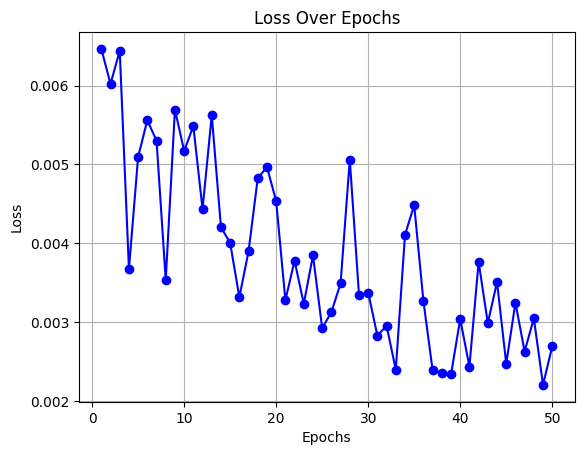

In [66]:
# Plot the loss graph
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

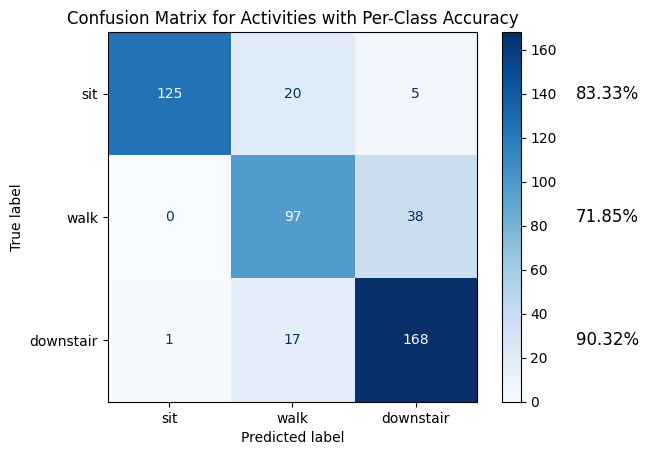

In [67]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','downstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

In [34]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 0, Predicted: 1, Confidence: 0.7656
Full Probabilities: [0.23438481986522675, 0.7656151652336121, 5.852364370895202e-09]
True Label: 0, Predicted: 1, Confidence: 0.7196
Full Probabilities: [0.2804323136806488, 0.7195668816566467, 7.486157755920431e-07]
True Label: 0, Predicted: 1, Confidence: 0.7455
Full Probabilities: [0.25449997186660767, 0.7454999089241028, 1.1570208613420618e-07]
True Label: 1, Predicted: 2, Confidence: 0.6533
Full Probabilities: [1.6420175597886555e-05, 0.3467133939266205, 0.6532701253890991]
True Label: 1, Predicted: 2, Confidence: 0.9890
Full Probabilities: [2.962098960779258e-06, 0.011044046841561794, 0.9889529943466187]
True Label: 1, Predicted: 2, Confidence: 0.9926
Full Probabilities: [3.0333814038385754e-07, 0.007360124960541725, 0.9926395416259766]
True Label: 1, Predicted: 2, Confidence: 0.9606
Full Probabilities: [0.0003620623319875449, 0.03904091939330101, 0.9605970978736877]
True Label: 1, Predicted: 2, Confidence: 0.9999
Full Probabilities